In [1]:
from pathlib import Path
import requests

In [18]:
covers = Path('book_cover_urls.txt').read_text().split('\n')
cover_dir = Path() / 'cover_images'
if not cover_dir.exists():
    cover_dir.mkdir()

In [85]:
for ix, c in enumerate(covers):    
    r = requests.get(c)
    with open(cover_dir / f'cover_{ix:02d}.jpg', 'wb') as f:
        f.write(r.content)

In [ ]:
from PIL import Image
import re

In [78]:
def merge_images(files, horizontal=True):
    """Merge list images into single row of images, displayed side by side
    :param list of files: path first image file
    :return: the merged Image object
    """
    img = []
    w = []
    h = []
    for f in files:
        if not isinstance(f, Image.Image):
            image = Image.open(f)
        else:
            image = f
        img.append(image)
        (width, height) = image.size
        w.append(width)
        h.append(height)

    if horizontal:
        result_width = sum(w)
        result_height = min(h)
    else:
        result_width = max(w)
        result_height = sum(h)
    
    result = Image.new('RGB', (result_width, result_height), color=(255,255,255,0))
    for ix, image in enumerate(img):
        if horizontal:
            width = sum(w[:ix])
            result.paste(im=image, box=(width, 0))
        else:
            height = sum(h[:ix])
            result.paste(im=image, box=(0, height))
    return result

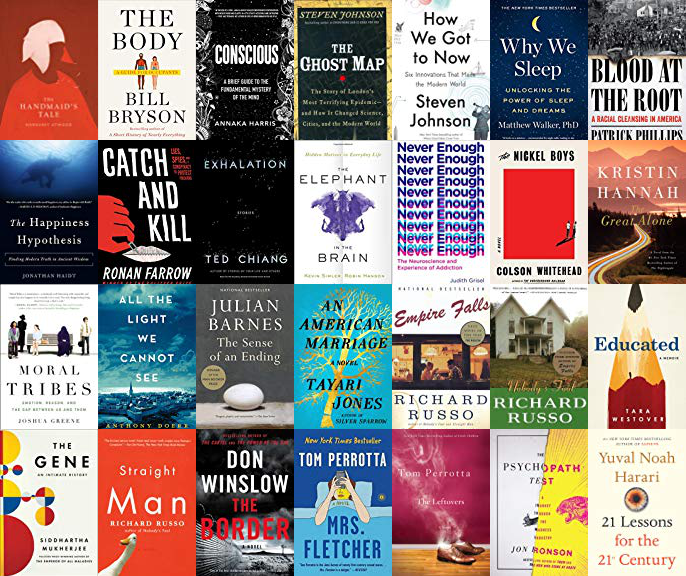

In [104]:
files = [f for f in cover_dir.iterdir() if re.match(r'cover_[0-9]{2}.jpg', f.name)]
files_to_drop = [28, 17, 30]
files = [f for f in files if int(re.search(r'cover_([0-9]{2}).jpg', f.name).group(1)) not in files_to_drop]
    
cols = 7

rows = []
for row in range(5):
    fls = files[cols * row:cols * row + cols]
    if len(fls) > 0:
        rows.append(merge_images(fls, True))
out = merge_images(rows, False)
out.save('composite.png')
out